### Install packages

In [1]:
%%bash
wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
chmod +x Miniconda3-latest-Linux-x86_64.sh
bash ./Miniconda3-latest-Linux-x86_64.sh  -b -f -p /usr/local
wget https://raw.githubusercontent.com/computational-chemical-biology/ChemWalker/master/environment.yml
conda env create -f environment.yml
#conda install -n chemwalker -c conda-forge multiprocessing

PREFIX=/usr/local
Unpacking payload ...

Installing base environment...





Preparing transaction: ...working... done
Executing transaction: ...working... done
installation finished.
    You currently have a PYTHONPATH environment variable set. This may cause
    unexpected behavior when running the Python interpreter in Miniconda3.
    For best results, please verify that your PYTHONPATH only points to
    directories of packages that are compatible with the Python interpreter
    in Miniconda3: /usr/local
Solving environment: ...working... done

mkl-2020.2           | 138.3 MB  |            |   0% 
jpeg-9b              | 214 KB    |            |   0% 

ncurses-6.2          | 817 KB    |            |   0% 


pandas-1.1.3         | 8.1 MB    |            |   0% 



readline-8.0         | 356 KB    |            |   0% 




libxcb-1.14          | 505 KB    |            |   0% 





rdkit-2020.09.1.0    | 25.8 MB   |            |   0% 






cairo-1.14.12        | 906 KB    |            

--2023-01-11 18:49:48--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72402405 (69M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

     0K .......... .......... .......... .......... ..........  0% 7.07M 10s
    50K .......... .......... .......... .......... ..........  0% 5.49M 11s
   100K .......... .......... .......... .......... ..........  0% 30.6M 8s
   150K .......... .......... .......... .......... ..........  0% 9.56M 8s
   200K .......... .......... .......... .......... ..........  0% 17.8M 7s
   250K .......... .......... .......... .......... ..........  0% 18.4M 7s
   300K .......... .......... .......... .......... ..........  0% 25.7M 6s
   350K .......... .......... .......... ....

In [2]:
# Install ChemWalker from github
!/usr/local/envs/chemwalker/bin/pip install git+https://github.com/computational-chemical-biology/ChemWalker.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/computational-chemical-biology/ChemWalker.git to /tmp/pip-req-build-lufduhd6
  Created wheel for chemwalker: filename=chemwalker-0.0.1-py3-none-any.whl size=30304 sha256=7716b77e157faf352e1b4ecf803b91b40f5afccf9ee9ab2514b0aa8dba2ba8f9
  Stored in directory: /tmp/pip-ephem-wheel-cache-7q9lh538/wheels/f6/a4/fe/121b2dd66fcae45d3a74553a5fb05094af46405fd2b4435427
Successfully built chemwalker


In [3]:
# Load libraries from colab default runtime
import sklearn
import multiprocessing
import pandas as pd
import ftplib
pd.__version__

'1.3.5'

In [4]:
# Load the remaining libraries from chemwalker env to keep versions consistent
import sys
sys.path = ['/usr/local/envs/chemwalker/lib/python3.7/site-packages']
sys.path

['/usr/local/envs/chemwalker/lib/python3.7/site-packages']

In [5]:
import networkx
networkx.__version__

'2.5'

### Load ChemWalker and auxiliary packages

In [6]:
import os
from chemwalker.gnps import Proteosafe
from chemwalker.utils import run_metfrag, walk_conn_comp, get_db
from chemwalker.draw import *
import numpy as np

### Retrieve data processed by [GNPS](https://gnps.ucsd.edu/) with taskid and obtain: 

net: spectral network; gnps: node attributes; spectra: fragmentation spectra; match: spectral library matches.

In [7]:
taskid = 'a0b4377f6e4540268602c30fedf69b0b'

gnps_result = Proteosafe(taskid, 'FBMN')
gnps_result.get_gnps()
net = gnps_result.net
gnps_tab = gnps_result.gnps
spectra = gnps_result.spectra
match_tab = gnps_result.dbmatch

In [8]:
# Inspect network
net.head()

,CLUSTERID1,CLUSTERID2,ComponentIndex,Cosine,DeltaMZ
0,150,350,1,0.6612,-197.089
1,205,617,1,0.9478,-0.000
2,617,3066,1,0.8151,154.091
3,37,69,1,0.8938,0.000
4,201,238,1,0.9712,34.021


In [9]:
net.shape

(406, 5)

In [10]:
# Number of nodes by connected component
net['ComponentIndex'].value_counts().to_dict()

{1: 177,
 3: 55,
 11: 49,
 8: 38,
 6: 32,
 5: 21,
 10: 18,
 15: 3,
 9: 2,
 12: 2,
 17: 2,
 7: 1,
 2: 1,
 4: 1,
 13: 1,
 14: 1,
 16: 1,
 18: 1}

In [11]:
nset = net['ComponentIndex'].unique().tolist()
nset

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [12]:
# Library matches
match_tab.head()

,SpectrumID,Compound_Name,Ion_Source,Instrument,Compound_Source,PI,Data_Collector,Adduct,Precursor_MZ,ExactMass,...,FileScanUniqueID,NumberHits,tags,MoleculeExplorerDatasets,MoleculeExplorerFiles,InChIKey,InChIKey-Planar,superclass,class,subclass
0,CCMSLIB00000852203,"NCGC00385365-01_C11H16O3_2(4H)-Benzofuranone, ...",LC-ESI,Maxis II HD Q-TOF Bruker,isolated,Jadhav/Dorrestein,lfnothias,M+H,197.117,196.110,...,spectra_filtered/specs_ms.mgf106,1,NaN,8,131,XEVQXKKKAVVSMW-WRWORJQWSA-N,XEVQXKKKAVVSMW,NaN,NaN,NaN
1,CCMSLIB00003139295,Spectral Match to (-)-Epicatechin from NIST14,ESI,Q-TOF,Isolated,Data from Souard,Data deposited by souardf,M+H,291.088,0.000,...,spectra_filtered/specs_ms.mgf1071,1,NaN,36,2325,NaN,NaN,NaN,NaN,NaN
2,CCMSLIB00000213963,Massbank:FIO00265 Velutin,ESI,LC-ESI-QTOF,Isolated,Putative Massbank Match,Massbank,[M+H]+,315.087,0.000,...,spectra_filtered/specs_ms.mgf1115,1,NaN,0,0,ROCUOVBWAWAQFD-UHFFFAOYSA-N,ROCUOVBWAWAQFD,Phenylpropanoids and polyketides,Flavonoids,O-methylated flavonoids
3,CCMSLIB00000846878,"NCGC00384563-01!5,7-dihydroxy-2-(4-hydroxyphen...",LC-ESI,Maxis II HD Q-TOF Bruker,isolated,Jadhav/Dorrestein,lfnothias,M+H,535.144,534.137,...,spectra_filtered/specs_ms.mgf1129,1,NaN,23,446,LDVNKZYMYPZDAI-UHFFFAOYSA-N,LDVNKZYMYPZDAI,Phenylpropanoids and polyketides,Flavonoids,Flavonoid glycosides
4,CCMSLIB00003236728,Narcissin,ESI,Q-TOF,Isolated,NIST,NIST,M+H,625.176,0.000,...,spectra_filtered/specs_ms.mgf1145,1,NaN,0,0,UIDGLYUNOUKLBM-UHFFFAOYSA-N,UIDGLYUNOUKLBM,Phenylpropanoids and polyketides,Flavonoids,Flavonoid glycosides


In [13]:
match_tab.columns

Index(['SpectrumID', 'Compound_Name', 'Ion_Source', 'Instrument',
       'Compound_Source', 'PI', 'Data_Collector', 'Adduct', 'Precursor_MZ',
       'ExactMass', 'Charge', 'CAS_Number', 'Pubmed_ID', 'Smiles', 'INCHI',
       'INCHI_AUX', 'Library_Class', 'IonMode', 'UpdateWorkflowName',
       'LibraryQualityString', '#Scan#', 'SpectrumFile', 'LibraryName',
       'MQScore', 'Organism', 'TIC_Query', 'RT_Query', 'MZErrorPPM',
       'SharedPeaks', 'MassDiff', 'LibMZ', 'SpecMZ', 'SpecCharge',
       'FileScanUniqueID', 'NumberHits', 'tags', 'MoleculeExplorerDatasets',
       'MoleculeExplorerFiles', 'InChIKey', 'InChIKey-Planar', 'superclass',
       'class', 'subclass'],
      dtype='object')

In [14]:
gnps_tab.head()

,ATTRIBUTE_AB,ATTRIBUTE_AFE,ATTRIBUTE_Asat,ATTRIBUTE_C,ATTRIBUTE_C/N,ATTRIBUTE_CMSF,ATTRIBUTE_CS,ATTRIBUTE_Family,ATTRIBUTE_Forest_Region,ATTRIBUTE_Genus,...,SpectrumID,SumPeakIntensity,UniqueFileSourcesCount,cluster index,componentindex,number of spectra,parent mass,precursor charge,precursor mass,sum(precursor intensity)
0,"0.01,0.006999999999999999,0.016,0.009000000000...","0.064,0.12,0.03,0.048","23.933000000000003,24.941,20.902,32.262","18.426,20.231,22.241,14.155",NaN,"484.18300000000005,464.898,456.674,459.564","0.135,0.211,0.132",Arecaceae,"Primary,Secondary",Euterpe,...,NaN,1.348335e+07,12,5,-1,12,353.2654,1,353.2654,1.348335e+07
1,"0.01,0.006999999999999999,0.016,0.009000000000...","0.064,0.12,0.03,0.048","23.933000000000003,24.941,20.902,32.262","18.426,20.231,22.241,14.155",NaN,"484.18300000000005,464.898,456.674,459.564","0.135,0.211,0.132",Arecaceae,"Primary,Secondary",Euterpe,...,NaN,1.274737e+07,12,7,-1,12,381.2963,1,381.2963,1.274737e+07
2,"0.01,0.006999999999999999,0.016,0.009000000000...","0.064,0.12,0.03,0.048","23.933000000000003,24.941,20.902,32.262","18.426,20.231,22.241,14.155",NaN,"484.18300000000005,464.898,456.674,459.564","0.135,0.211,0.132",Arecaceae,"Primary,Secondary",Euterpe,...,NaN,1.215391e+07,12,8,11,12,581.1482,1,581.1482,1.215391e+07
3,"0.01,0.006999999999999999,0.016,0.009000000000...","0.064,0.12,0.03,0.048","23.933000000000003,24.941,20.902,32.262","18.426,20.231,22.241,14.155",NaN,"484.18300000000005,464.898,456.674,459.564","0.135,0.211,0.132",Arecaceae,"Primary,Secondary",Euterpe,...,NaN,1.239457e+07,11,10,8,11,609.2684,1,609.2684,1.239457e+07
4,"0.01,0.006999999999999999,0.016,0.009000000000...","0.064,0.12,0.03,0.048","23.933000000000003,24.941,20.902,32.262","18.426,20.231,22.241,14.155",NaN,"484.18300000000005,464.898,456.674,459.564","0.135,0.211,0.132",Arecaceae,"Primary,Secondary",Euterpe,...,NaN,6.553864e+06,11,13,-1,11,305.1565,1,305.1565,6.553864e+06


In [15]:
spectra[0]

{'params': {'feature_id': '5',
  'pepmass': (353.2654, None),
  'scans': '5',
  'rtinseconds': 2107.174 second,
  'charge': [1],
  'mslevel': '2'},
 'm/z array': array([353.2602, 354.2637, 355.2699, 400.2479]),
 'intensity array': array([2000.,  590.,   74.,   62.]),
 'charge array': masked_array(data=[--, --, --, --],
              mask=[ True,  True,  True,  True],
        fill_value=0,
             dtype=int64)}

In [16]:
gnps_result.check_comp(11)

Component of 12 nodes, with 6 InChI or Smiles present.


### Retrieve example structure database

In [17]:
db = get_db()
db.head()

,MonoisotopicMass,InChI,SMILES,Identifier,InChIKey2,InChIKey1,MolecularFormula,kingdom_name,superclass_name,class_name,subclass_name
0,194.05791,InChI=1/C10H10O4/c1-14-9-6-7(2-4-8(9)11)3-5-10...,COC1=C(C=CC(=C1)C=CC(=O)O)O,CCMSLIB00000220714,UHFFFAOYSA,KSEBMYQBYZTDHS,C10H10O4,Organic compounds,Phenylpropanoids and polyketides,Cinnamic acids and derivatives,Hydroxycinnamic acids and derivatives
1,176.09496,InChI=1/C10H12N2O/c11-4-3-7-6-12-10-2-1-8(13)5...,C1=CC2=C(C=C1O)C(=CN2)CCN,CCMSLIB00000220735,UHFFFAOYSA,QZAYGJVTTNCVMB,C10H12N2O,Organic compounds,Organoheterocyclic compounds,Indoles and derivatives,Tryptamines and derivatives
2,176.04734,InChI=1/C10H8O3/c1-6-4-10(12)13-9-5-7(11)2-3-8...,CC1=CC(=O)OC2=C1C=CC(=C2)O,CCMSLIB00000221773,UHFFFAOYSA,HSHNITRMYYLLCV,C10H8O3,NaN,NaN,NaN,NaN
3,345.07864,"InChI=1/C12H17N4O4PS/c1-8-11(3-4-20-21(17,18)1...",CC1=C(SC=[N+]1CC2=CN=C(N=C2N)C)CCOP(=O)(O)O,CCMSLIB00000221098,UHFFFAOYSA,HZSAJDVWZRBGIF,C12H18N4O4PS,Organic compounds,Organoheterocyclic compounds,Diazines,Pyrimidines and pyrimidine derivatives
4,342.11621,InChI=1/C12H22O11/c13-1-4-6(15)8(17)9(18)11(22...,C(C1C(C(C(C(O1)OCC2C(C(C(O2)(CO)O)O)O)O)O)O)O,CCMSLIB00000222747,UHFFFAOYSA,PVXPPJIGRGXGCY,C12H22O11,NaN,NaN,NaN,NaN


In [18]:
db.shape

(367204, 11)

### Retrieve and test MetFrag2.3.-CL

In [19]:
!wget http://ccbl.fcfrp.usp.br/ccbl/MetFrag2.3-CL.jar

--2023-01-11 18:54:37--  http://ccbl.fcfrp.usp.br/ccbl/MetFrag2.3-CL.jar
Resolving ccbl.fcfrp.usp.br (ccbl.fcfrp.usp.br)... 200.144.245.3
Connecting to ccbl.fcfrp.usp.br (ccbl.fcfrp.usp.br)|200.144.245.3|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34448208 (33M) [application/java-archive]
Saving to: ‘MetFrag2.3-CL.jar’

MetFrag2.3-CL.jar   100%[===================>]  32.85M  10.6MB/s    in 3.1s    

2023-01-11 18:54:41 (10.6 MB/s) - ‘MetFrag2.3-CL.jar’ saved [34448208/34448208]



In [20]:
# https://ipb-halle.github.io/MetFrag/projects/metfragcl/
metpath = os.path.abspath('MetFrag2.3-CL.jar')
metpath

'/content/MetFrag2.3-CL.jar'

In [21]:
sys.path.append('/usr/local/envs/chemwalker/lib/python3.7/site-packages')
from chemwalker.utils import *
print(sys.path)

print("Python version")
print(sys.version)

['/usr/local/envs/chemwalker/lib/python3.7/site-packages', '/usr/local/envs/chemwalker/lib/python3.7/site-packages']
Python version
3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]


In [22]:
gnps_tab.shape

(486, 117)

In [23]:
len(spectra)

486

In [24]:
gnps_tab.head()

,ATTRIBUTE_AB,ATTRIBUTE_AFE,ATTRIBUTE_Asat,ATTRIBUTE_C,ATTRIBUTE_C/N,ATTRIBUTE_CMSF,ATTRIBUTE_CS,ATTRIBUTE_Family,ATTRIBUTE_Forest_Region,ATTRIBUTE_Genus,...,SpectrumID,SumPeakIntensity,UniqueFileSourcesCount,cluster index,componentindex,number of spectra,parent mass,precursor charge,precursor mass,sum(precursor intensity)
0,"0.01,0.006999999999999999,0.016,0.009000000000...","0.064,0.12,0.03,0.048","23.933000000000003,24.941,20.902,32.262","18.426,20.231,22.241,14.155",NaN,"484.18300000000005,464.898,456.674,459.564","0.135,0.211,0.132",Arecaceae,"Primary,Secondary",Euterpe,...,NaN,1.348335e+07,12,5,-1,12,353.2654,1,353.2654,1.348335e+07
1,"0.01,0.006999999999999999,0.016,0.009000000000...","0.064,0.12,0.03,0.048","23.933000000000003,24.941,20.902,32.262","18.426,20.231,22.241,14.155",NaN,"484.18300000000005,464.898,456.674,459.564","0.135,0.211,0.132",Arecaceae,"Primary,Secondary",Euterpe,...,NaN,1.274737e+07,12,7,-1,12,381.2963,1,381.2963,1.274737e+07
2,"0.01,0.006999999999999999,0.016,0.009000000000...","0.064,0.12,0.03,0.048","23.933000000000003,24.941,20.902,32.262","18.426,20.231,22.241,14.155",NaN,"484.18300000000005,464.898,456.674,459.564","0.135,0.211,0.132",Arecaceae,"Primary,Secondary",Euterpe,...,NaN,1.215391e+07,12,8,11,12,581.1482,1,581.1482,1.215391e+07
3,"0.01,0.006999999999999999,0.016,0.009000000000...","0.064,0.12,0.03,0.048","23.933000000000003,24.941,20.902,32.262","18.426,20.231,22.241,14.155",NaN,"484.18300000000005,464.898,456.674,459.564","0.135,0.211,0.132",Arecaceae,"Primary,Secondary",Euterpe,...,NaN,1.239457e+07,11,10,8,11,609.2684,1,609.2684,1.239457e+07
4,"0.01,0.006999999999999999,0.016,0.009000000000...","0.064,0.12,0.03,0.048","23.933000000000003,24.941,20.902,32.262","18.426,20.231,22.241,14.155",NaN,"484.18300000000005,464.898,456.674,459.564","0.135,0.211,0.132",Arecaceae,"Primary,Secondary",Euterpe,...,NaN,6.553864e+06,11,13,-1,11,305.1565,1,305.1565,6.553864e+06


In [25]:
run_metfrag(spectra[0], db, cluster_index=5, **{'metpath': metpath})

,Score,InChI,FragmenterScore_Values,MaximumTreeDepth,SmilesOfExplPeaks,MonoisotopicMass,Identifier,MolecularFormula,FormulasOfExplPeaks,InChIKey2,InChIKey1,FragmenterScore,ExplPeaks,NoExplPeaks,NumberPeaksUsed,cluster index
0,0.0,InChI=1S/C21H36O4/c1-2-3-4-5-6-7-8-9-10-11-12-...,NaN,2,NaN,352.26136,HMDB11570,C21H36O4,NaN,IWFQAGGASA,GGJRAQULURVTAJ,0.0,NaN,0,0,5
1,0.0,InChI=1S/C21H36O4/c1-2-3-4-5-6-7-8-9-10-11-12-...,NaN,2,NaN,352.26136,HMDB11569,C21H36O4,NaN,FFXVNFNPSA,XQBHBEXBUZDCRY,0.0,NaN,0,0,5
2,0.0,InChI=1S/C21H36O4/c1-2-3-4-5-6-7-8-9-10-11-12-...,NaN,2,NaN,352.26136,HMDB11540,C21H36O4,NaN,PDBXOOCHSA,ZCCLDKGWJIREQF,0.0,NaN,0,0,5
3,0.0,InChI=1S/C21H36O4/c1-2-3-4-5-6-7-8-9-10-11-12-...,NaN,2,NaN,352.26136,HMDB11539,C21H36O4,NaN,QNEBEIHSSA,BXAXVVVVPFELOK,0.0,NaN,0,0,5
4,0.0,InChI=1S/C17H30N6O2/c1-21(2)9-14-10-23(20-19-1...,NaN,2,NaN,352.25867,SN00003763,C17H32N6O2+2,NaN,IMJJTQAJSA,ARTRYHKUYFBLMW,0.0,NaN,0,0,5
5,0.0,InChI=1S/C21H36O4/c1-12(2)14-8-7-13(3)17-15-11...,NaN,2,NaN,352.26136,SN00336671,C21H36O4,NaN,FQOJGSFKSA,OEUGMHUKLQIMAL,0.0,NaN,0,0,5
6,0.0,InChI=1S/C21H36O4/c1-12(22)15-7-9-21(25)16-5-4...,NaN,2,NaN,352.26136,SN00314125,C21H36O4,NaN,ISKWUEMLSA,FTIPFRDCMUGVRU,0.0,NaN,0,0,5
7,0.0,InChI=1S/C21H36O4/c1-12(22)21(25)9-7-16-15-5-4...,NaN,2,NaN,352.26136,SN00365925,C21H36O4,NaN,HHDQNTOOSA,ICLJUDISOCRJDM,0.0,NaN,0,0,5
8,0.0,InChI=1S/C21H36O4/c1-13(11-18(23)25-6)7-9-20(4...,NaN,2,NaN,352.26136,SN00257279,C21H36O4,NaN,FCFMDSSISA,QFSPHXMKLQWTLA,0.0,NaN,0,0,5
9,0.0,InChI=1S/C21H36O4/c1-14(10-13-25-6)8-9-15-20(4...,NaN,2,NaN,352.26136,SN00267497,C21H36O4,NaN,GPLUPSNSSA,KOMLQPBMYPUDGX,0.0,NaN,0,0,5


### Perform propagation inside a given connected component

In [26]:
%%time

tlid = walk_conn_comp(net=net, spectra=spectra, tabgnps=gnps_tab, 
                      dbmatch=match_tab.copy(), db=db, comp_index=10,
                      metpath=metpath)

Component with 9 nodes
Calculating in silico fragmentation with MetFrag...
in silico fragmentation done in: 275.28226709365845 seconds
Calculating pairwise candidate similarities...
similarities done in: 49.49723958969116 seconds
Seed - InChIKey1:XFZJEEAOWLFHDH, cluster index:1412, Identifier:CCMSLIB00003232154
Seed - InChIKey1:XFZJEEAOWLFHDH, cluster index:1647, Identifier:CCMSLIB00003232153
Walking on the graph...
walking done in: 0.040038108825683594 seconds
CPU times: user 6.81 s, sys: 793 ms, total: 7.6 s
Wall time: 5min 24s


In [27]:
net[net['ComponentIndex']==10]

,CLUSTERID1,CLUSTERID2,ComponentIndex,Cosine,DeltaMZ
328,387,830,10,0.8632,0.000
329,112,1412,10,0.7365,-15.995
330,1412,3007,10,0.6886,16.025
331,112,3007,10,0.7893,0.030
332,112,1076,10,0.8131,15.996
333,307,1647,10,0.7289,-15.994
334,307,1412,10,0.7428,-15.994
335,112,1647,10,0.7088,-15.995
336,307,1076,10,0.7793,15.997
337,1647,3007,10,0.7130,16.025


### Inspect results

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


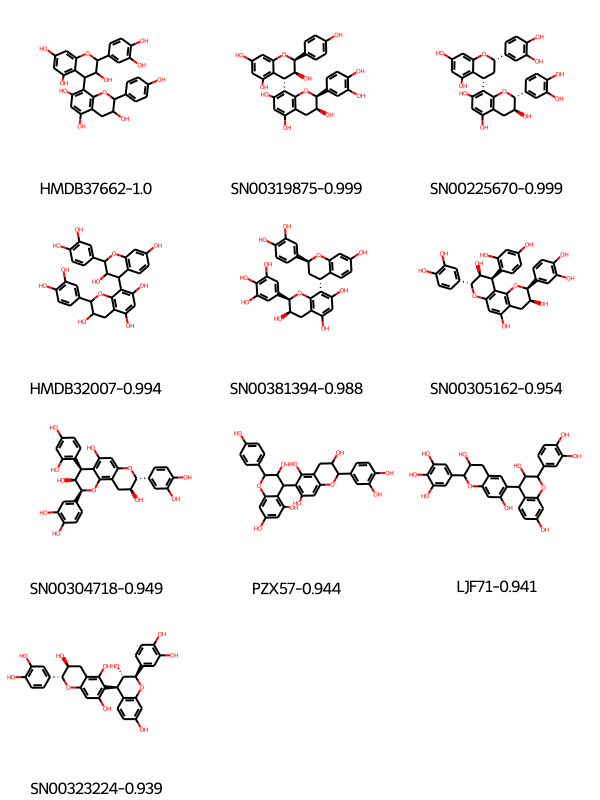

In [28]:
plotPannel(tlid, clusterid=112)

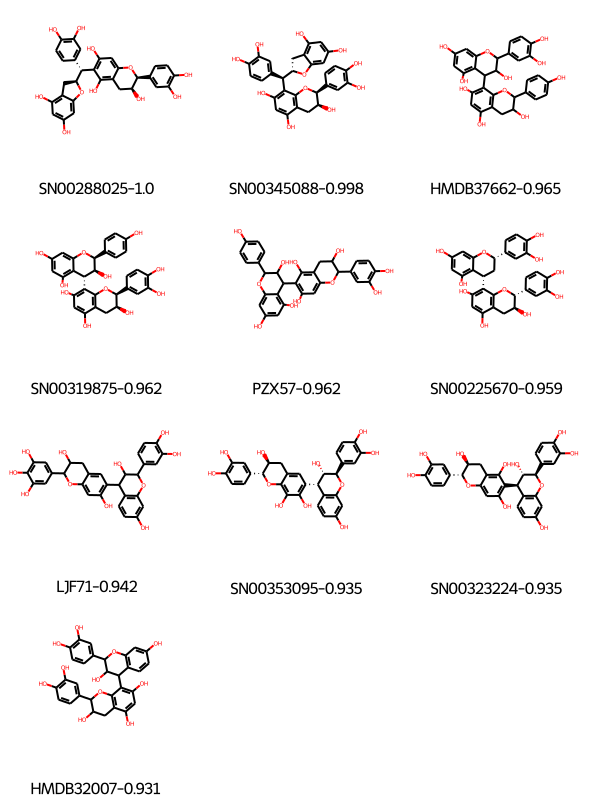

In [29]:
plotPannel(tlid, clusterid=112, score='Score')

In [30]:
if not os.path.exists('figs'):
    os.mkdir('figs')

plotGraph(match_tab, gnps_tab, tlid, net, method='MF',
         dr='figs', comp=10, option=1, pos_scale=300)
    
plotGraph(match_tab, gnps_tab, tlid, net, method='RW',
         dr='figs', comp=10, option=1, pos_scale=300)

In [31]:
tlid['cluster index'].value_counts()

1076    43
112     33
307     33
387     10
1108    10
830     10
3007     4
1412     1
1647     1
Name: cluster index, dtype: int64

In [32]:
!ls

comp_10_MF.html  figs				    sample_data
comp_10_RW.html  MetFrag2.3-CL.jar
environment.yml  Miniconda3-latest-Linux-x86_64.sh


### Create a compressed file with interactive html for download

Click the folder icon and download the file.

In [33]:
!zip -r res_chw.zip figs/ comp_10_MF.html comp_10_RW.html

  adding: figs/ (stored 0%)
  adding: figs/MF_830.png (deflated 4%)
  adding: figs/LM_1647.png (deflated 4%)
  adding: figs/MF_387.png (deflated 4%)
  adding: figs/MF_112.png (deflated 5%)
  adding: figs/RW_3007.png (deflated 7%)
  adding: figs/RW_307.png (deflated 4%)
  adding: figs/RW_112.png (deflated 4%)
  adding: figs/RW_1108.png (deflated 4%)
  adding: figs/RW_1076.png (deflated 4%)
  adding: figs/MF_1108.png (deflated 4%)
  adding: figs/MF_307.png (deflated 5%)
  adding: figs/RW_830.png (deflated 4%)
  adding: figs/MF_1076.png (deflated 4%)
  adding: figs/LM_1412.png (deflated 4%)
  adding: figs/RW_387.png (deflated 4%)
  adding: figs/MF_3007.png (deflated 7%)
  adding: comp_10_MF.html (deflated 78%)
  adding: comp_10_RW.html (deflated 78%)
